# DQNに秘書を面接させたら、美しい結果が得られた話

秘書とは「複雑に入り組んだ現代社会に鋭いメスを入れ、様々な謎や疑問を徹底的に究明する探偵！ナイトスクープ。私が局長の西田敏行（上岡龍太郎）でございます。そして」の次に話す人のことです。主に関西地方ではね。

本稿は、**秘書問題**をDQNに解かせてみたら、美しい結果が得られたという話です。

--

【2018/9/1追記】

- プログラムで、カウントアップの位置を間違えるという、信じられないミスをやらかしていたので、再度訓練し、原稿を修正しました。幸いなことに、美しい結果が得られることに変わりありませんでした。「錯覚いけない、よく見るよろし」ですね。

## 秘書問題とは

以下、[Wikipedia](https://ja.wikipedia.org/wiki/%E7%A7%98%E6%9B%B8%E5%95%8F%E9%A1%8C)よりの引用です。

秘書問題（英: secretary problem）は、最適停止問題の一種で、応用確率論、統計学、決定理論の分野で特に研究されている。結婚問題 (marriage problem)、スルターンの持参金問題 (sultan's dowry problem)、最良選択問題 (best choice problem) などともいう。具体的には、次のような問題である。

1. 秘書を1人雇いたいとする。
1. n人が応募してきている。nという人数は既知である。
1. 応募者には順位が付けられ、複数の応募者が同じ順位になることはない（1位からn位まで重複無く順位付けできる）。
1. 無作為な順序で1人ずつ面接を行う。次に誰を面接するかは常に同じ確率である。
1. 毎回の面接後、その応募者を採用するか否かを即座に決定する。
1. その応募者を採用するか否かは、それまで面接した応募者の相対的順位にのみ基づいて決定する。
1. 不採用にした応募者を後から採用することはできない。
1. このような状況で、最良の応募者を選択することが問題の目的である。

## 数学的性質

### 性質

特にnが大きい場合、最適ポリシーでは最初のn/e人の応募者をスキップし（eはネイピア数）、それ以降に面接した応募者がそれまでよりよいと判断したら採用する。 nが大きくなると最善の応募者を選択する確率は1/eすなわち約37%になる。応募者が100人でも100,000,000人であっても、最適ポリシーに従えば約37%の確率で最善の応募者を選択できる。

### 証明

以下サイトを参照してください。

- [高校数学の美しい物語／秘書問題（お見合い問題）とその解法](https://mathtrain.jp/hisyomondai)

証明が一読で理解できない人（＝私）は、変数を具体的な数値に置き換え（n=10, k=3, t=4, 5 ... 10）、Σを展開し、さらに、以下の微分公式をおさらいの上、丁寧に追いかけていけば、きっと理解できるはずです。

- 積の微分：$$ \{f(x)g(x)\}' = f'(x)g(x) + f(x)g'(x) $$

- 対数関数の微分：$$ (\log x)' = \frac{1}{x} $$

- 1/xの微分：$$ \left( \frac{1}{x} \right)' = - \frac{1}{x^2} $$

- 合成関数の微分（連鎖律）：$$ \frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx} $$

## DQNとは

DQN（deep Q-network）とは、機械学習の一種である強化学習（Q学習）において、Q値——ある行動から得られる報酬の見込みに比例した数値であり、行動指針となるもの——をニューラルネットワークで近似する手法となります。

というよりも、「ブロック崩し」のような往年のビデオゲームを何度も繰り返しプレーして、ルールを覚えて、コツを掴んで、攻略法まで編み出してしまうすごいやつ、といったほうが通りが良いかもしれませんね。

[![DQN Breakout](http://img.youtube.com/vi/TmPfTpjtdgg/0.jpg)](http://www.youtube.com/watch?v=TmPfTpjtdgg)

DQNの実装が「Keras-RL」というパッケージで提供されています。また、Keras-RLでプレーできるゲームが「OpenAI Gym」として提供されています。これらをインストールすることで、DQNをすぐに試してみることができます。

私の環境は[Python＋Pipenv](https://qiita.com/tanuk1647/items/cad362af79f528a5c348)ですので、仮想環境を作成し、TensorFlowとKerasをインストールしたのち、以下コマンドで、Keras-RLとOpenAI Gymをインストールしました。

```bash
$ pipenv install keras-rl
$ pipenv install gym
```


## 秘書問題のゲーム化

抽象クラス[gym.Env](https://github.com/openai/gym/blob/master/gym/core.py)を継承のうえ、必須項目を実装していきます。具体的な実装内容は、後述のソースコードを参照してください。なお、応募者数は10人としました。訓練にかかる時間を短縮するためです。

**action_space**

- 行動空間。プレーヤーの行動の選択肢の数だけ「幅」を持つ。今回は、採用／不採用の2値としました。

**observation_space**

- 観測空間。プレーヤーが観測可能な2次元の「広さ」と、その取りうる値の「高さ」を持つ。今回は、1〜10までの値を取りうる3次元ベクトルとしました。内訳は、１）それまで面接した応募者の相対的順位（暫定順位）、２）何人目の面接か、３）応募者数。

**step**

- ゲームを1ステップ進める。

**reset**

- ゲームの状態をリセットする。

**render**

- 画面をレンダリングする。

**reward**

- 報酬。悩ましいところですが、最善の応募者を採用できた場合は1000点、次善以下の応募者を採用した場合は0点、一人も採用できず面接を終えた場合も0点としました。


## DQNの構築

Keras-RLは、Kerasと同レベルに抽象化されているので、シンプルに書けます。モデルの初期化、訓練、テストについて書きました。具体的な実装内容は、後述のソースコードを参照してください。

モデルの初期化については、Kerasでニューラルネットワークを作成したのち、DQNのエージェントを作成し、コンパイルします。ネットワークは中間層3層、ユニット数256、活性化関数はReLU（ランプ関数）を用いました。DQNのポリシーとしては、ボルツマン選択（BoltzmannQPolicy）を指定しました。Q値に基づいた確率的行動をとるはずです。

訓練やテストについては、DQNのfitメソッド、testメソッドを呼び出すのみです。その際、作ったゲーム（環境）を渡してやります。訓練の際は、Q値の収束状況を可視化するために、ロガーを仕込んだりもします。fitの戻り値のhistoryにQ値が含まれないので…。

その他、ハイパーパラメータは、動かしながら調整しました。

## ソースコード

以下、ソースコードです。長いので、ご興味のある方以外は、スクロールして飛ばしてください。

In [1]:
import sys
from os import mkdir
from os.path import exists
from sys import exc_info
import numpy as np
from enum import IntEnum
from scipy.stats import rankdata
import gym
from gym import spaces
from gym.utils import seeding
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import TrainIntervalLogger, TrainEpisodeLogger
import matplotlib.pyplot as plt


NUMS = 10  # 応募者数


class Result(IntEnum):
    non_adopt = 0
    adopt = 1


class Secretary(gym.Env):
    metadata = {
        'render.modes': ['human', 'ansi']
    }
    
    action_space = spaces.Discrete(2)  # 不採用／採用
    reward_range = [0., 1000.]
    
    def __init__(self, n=100):
        super().__init__()
        if n <= 0:
            raise ValueError('nは1以上の整数を指定してください')
        self.n = n
        self.adopted = []
        self.best_applicant = []
        self.observation_space = spaces.Box(low=0, high=self.n,
                                            shape=(3,), dtype='float32')
        self.seed()
    
    def __call_next(self):
        self.interviewees.append(self.applicants.pop())
        return int(rankdata(self.interviewees)[-1])
    
    def reset(self):
        # 初期化
        self.cnt = 1
        self.done = False
        self.applicants = [a for a in range(1, self.n + 1)]
        self.np_random.shuffle(self.applicants)
        self.best_applicant += [len(self.applicants) - np.where(np.array(self.applicants) == 1)[0][0]]
        self.adopted += [0]
        self.interviewees = []
        
        # 一人目
        self.interviewee = self.__call_next()
        self.observation = [self.interviewee, self.cnt, self.n]
        return self.observation
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        if action == Result.adopt:
            self.adopted[-1] = self.cnt
            if self.interviewees[-1] == 1:
                self.reward = 1000.
            else:
                self.reward = 0.
            self.done = True
            self.observation = [self.interviewee, self.cnt, self.n]
        
        elif action == Result.non_adopt:
            if len(self.applicants) == 0:  # 全員面接した
                self.adopted[-1] = None
                self.reward = 0.
                self.done = True
                self.observation = [self.interviewee, self.cnt, self.n]
            else:
                self.reward = 0.
                self.done = False
                self.interviewee = self.__call_next()
                self.cnt += 1
                self.observation = [self.interviewee, self.cnt, self.n]
        
        return self.observation, self.reward, self.done, {}
    
    def render(self, mode='human', close=False):
        if mode == 'ansi':
            outfile = StringIO()
        elif mode == 'human':
            outfile = sys.stdout
        else:
            # just raise an exception
            super().render(mode=mode)
        
        s = ''
        if self.done:
            if self.reward > 0:
                s = '\nおめでとうございます！  最良の応募者を採用できました。\n'
            elif self.adopted[-1] is None:
                s = '\nあなたは誰も採用しませんでした。\n'
                s += '最良の応募者は' + str(self.best_applicant[-1]) + '人目でした。\n'
            elif self.reward <= 0:
                s = '\nあなたは' + str(self.interviewees[-1]) + '番目に優秀な応募者を採用しました。\n'
                s += '最良の応募者は' + str(self.best_applicant[-1]) + '人目でした。\n'
        else:
            s = '\n' + str(self.n) + '人中' + str(self.cnt) + '人目（暫定順位：' + str(self.interviewee) + '位）\n'
        
        outfile.write(s)
        return outfile
    
    def close(self):
        # just return
        super().close()
    
    def play(self):
        self.reset()
        while not self.done:
            print(self.applicants, self.interviewees)
            self.render()
            print('採用しますか？')
            self.step(self.__input())
            if self.done:
                self.render()
                break
    
    def __input(self):
        while True:
            print('[採用しない：0、採用する：1]')
            i = input()
            if i in ['0', '1']:
                break
            print('入力値が不正です。')
        return int(i)


class TrainIntervalLogger2(TrainIntervalLogger):
    def __init__(self, interval=10000):
        super().__init__(interval=interval)
        self.records = {}
    
    def on_train_begin(self, logs):
        super().on_train_begin(logs)
        self.records['interval'] = []
        self.records['episode_reward'] = []
        for metrics_name in self.metrics_names:
            self.records[metrics_name] = []
    
    def on_step_begin(self, step, logs):
        if self.step % self.interval == 0:
            if len(self.episode_rewards) > 0:
                self.records['interval'].append(self.step // self.interval)
                self.records['episode_reward'].append(np.mean(self.episode_rewards))
                metrics = np.array(self.metrics)
                assert metrics.shape == (self.interval, len(self.metrics_names))
                if not np.isnan(metrics).all():  # not all values are means
                    means = np.nanmean(self.metrics, axis=0)
                    assert means.shape == (len(self.metrics_names),)
                    for name, mean in zip(self.metrics_names, means):
                        self.records[name].append(mean)
        super().on_step_begin(step, logs)


class DQNSecretary:
    # 重み保存先
    weightdir = './data'
    weightfile = './data/dqn_{}_weights.h5'
    
    # モデルの初期化
    def __init__(self, n=100, recycle=True):
        print('モデルを作成します。')
        self.train_interval_logger = None
        
        # Get the environment and extract the number of actions.
        self.env = Secretary(n=n)
        self.env_name = 'secretary'
        self.weightfile = self.__class__.weightfile.format(self.env_name)
        self.nb_actions = self.env.action_space.n
        
        # Next, we build a very simple model.
        self.model = Sequential()
        self.model.add(Flatten(input_shape=(1,) + self.env.observation_space.shape))
        self.model.add(Dense(256))
        self.model.add(Activation('relu'))
        self.model.add(Dense(256))
        self.model.add(Activation('relu'))
        self.model.add(Dense(256))
        self.model.add(Activation('relu'))
        self.model.add(Dense(self.nb_actions))
        self.model.add(Activation('linear'))
        #print(self.model.summary())
        
        # Finally, we configure and compile our agent.
        # You can use every built-in Keras optimizer and even the metrics!
        memory = SequentialMemory(limit=50000, window_length=1)
        policy = BoltzmannQPolicy(tau=1.)
        self.dqn = DQNAgent(model=self.model, nb_actions=self.nb_actions, memory=memory,
                            nb_steps_warmup=1000, target_model_update=1e-2, policy=policy)
        self.dqn.compile(Adam(lr=1e-3), metrics=[])
        
        self.__istrained = False
        print('モデルを作成しました。')
        
        if recycle:
            if exists(self.weightfile):
                try:
                    print('訓練済み重みを読み込みます。')
                    self.dqn.load_weights(self.weightfile)
                    self.__istrained = True
                    print('訓練済み重みを読み込みました。')
                    return None
                except:
                    print('訓練済み重みの読み込み中にエラーが発生しました。')
                    print('Unexpected error:', exc_info()[0])
                    raise
            else:
                print('訓練済み重みが存在しません。訓練を行ってください。')
    
    # 訓練
    def train(self, nb_steps=30000, verbose=1, visualize=False, log_interval=3000):
        if self.__istrained:
            raise RuntimeError('このモデルは既に訓練済みです。')
        
        print('訓練を行うので、お待ちください。')
        
        # 訓練実施
        # Okay, now it's time to learn something!
        # We visualize the training here for show, but this slows down training quite a lot.
        # You can always safely abort the training prematurely using Ctrl + C.
        callbacks = []
        if verbose == 1:
            self.train_interval_logger = TrainIntervalLogger2(interval=log_interval)
            callbacks.append(self.train_interval_logger)
            verbose = 0
        elif verbose > 1:
            callbacks.append(TrainEpisodeLogger())
            verbose = 0
        
        hist = self.dqn.fit(self.env, nb_steps=nb_steps,
                            callbacks=callbacks, verbose=verbose,
                            visualize=visualize, log_interval=log_interval)
        self.__istrained = True
        
        if self.train_interval_logger is not None:
            # 訓練状況の可視化
            interval = self.train_interval_logger.records['interval']
            episode_reward = self.train_interval_logger.records['episode_reward']
            mean_q = self.train_interval_logger.records['mean_q']
            if len(interval) > len(mean_q):
                mean_q = np.pad(mean_q, [len(interval) - len(mean_q), 0], "constant")
            plt.figure()
            plt.plot(interval, episode_reward, marker='.', label='報酬')
            plt.plot(interval, mean_q, marker='.', label='Q値')
            plt.legend(loc='best', fontsize=10)
            plt.grid()
            plt.xlabel('interval')
            plt.ylabel('score')
            plt.title('訓練状況')
            plt.xticks(np.arange(min(interval),
                                 max(interval) + 1,
                                 (max(interval) - min(interval))//7))
            plt.show()
        
        # 重みの保存
        if not exists(self.__class__.weightdir):
            try:
                mkdir(self.__class__.weightdir)
            except:
                print('重み保存フォルダの作成中にエラーが発生しました。')
                print('Unexpected error:', exc_info()[0])
                raise
        try:
            # After training is done, we save the final weights.
            self.dqn.save_weights(self.weightfile, overwrite=True)
        except:
            print('重みの保存中にエラーが発生しました。')
            print('Unexpected error:', exc_info()[0])
            raise
        
        return hist
    
    # テスト
    def test(self, nb_episodes=10, visualize=True, verbose=1):
        # Finally, evaluate our algorithm for 5 episodes.
        hist = self.dqn.test(self.env, nb_episodes=nb_episodes,
                             verbose=verbose, visualize=visualize)
        return hist


def visualize_adopting(env):
    plt.figure()
    x = range(1, len(env.adopted) + 1)
    plt.plot(x, env.adopted, marker='.', label='採用者')
    plt.plot(x, env.best_applicant, marker='.', alpha=0.5, label='最良の応募者')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('試行回数')
    plt.ylabel('面接者数')
    plt.ylim(0, env.n)
    plt.title('面接／採用状況（n=' + str(NUMS) + '）')
    plt.show()


def visualize_q(dqn_agent, rank):
    x = range(1, NUMS + 1)
    y = []
    z = []
    
    for i in x:
        y += [d.dqn.compute_q_values([[rank, i, NUMS]])[1]]
        z += [d.dqn.compute_q_values([[rank, i, NUMS]])[0]]
    
    mx = int(max([max(y), max(z)]))
    mn = int(min([min(y), min(z)]))
    
    s = [NUMS / np.e for _ in range(mn, mx)]
    t = range(mn, mx)

    plt.figure()
    plt.plot(x, y, marker='.', label='採用する')
    plt.plot(x, z, marker='.', alpha=0.5, label='採用しない')
    plt.plot(s, t, marker='.', alpha=0.5, label='x = n / e')
    plt.legend(loc='best', fontsize=10)
    plt.grid()
    plt.xlabel('人数')
    plt.ylabel('Q値')
    plt.title('Q値（n=' + str(NUMS) + '、相対順位=' + str(rank) + '）')
    plt.show()

Using TensorFlow backend.


## 人間がプレーする

人間がプレーすることもできます。ゲームを正しく実装できていることを確認するために使いました。

In [2]:
#env = Secretary(n=10)
#env.play()

## DQNにプレーさせる

さて、正しく実装できていることを確認できたら、DQNにプレー（訓練）させてみましょう。

モデルを作成します。
モデルを作成しました。
訓練を行うので、お待ちください。
Training for 20000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 1s 750us/step - reward: 35.0000
319 episodes - episode_reward: 109.718 [0.000, 1000.000]

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 6s 6ms/step - reward: 68.0000
365 episodes - episode_reward: 186.301 [0.000, 1000.000] - loss: 19817.920 - mean_q: 211.492

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 5s 5ms/step - reward: 55.0000
147 episodes - episode_reward: 374.150 [0.000, 1000.000] - loss: 19572.604 - mean_q: 321.105

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 5s 5ms/step - reward: 48.0000
134 episodes - episode_reward: 358.209 [0.000, 1000.000] - loss: 18574.088 - mean_q: 318.808

Interval 5 (4000 steps performed)
1000/1000 [==============================] - 5s 5ms/step - reward: 58.0000
137 episodes - episode_reward: 423.358 [0.000, 

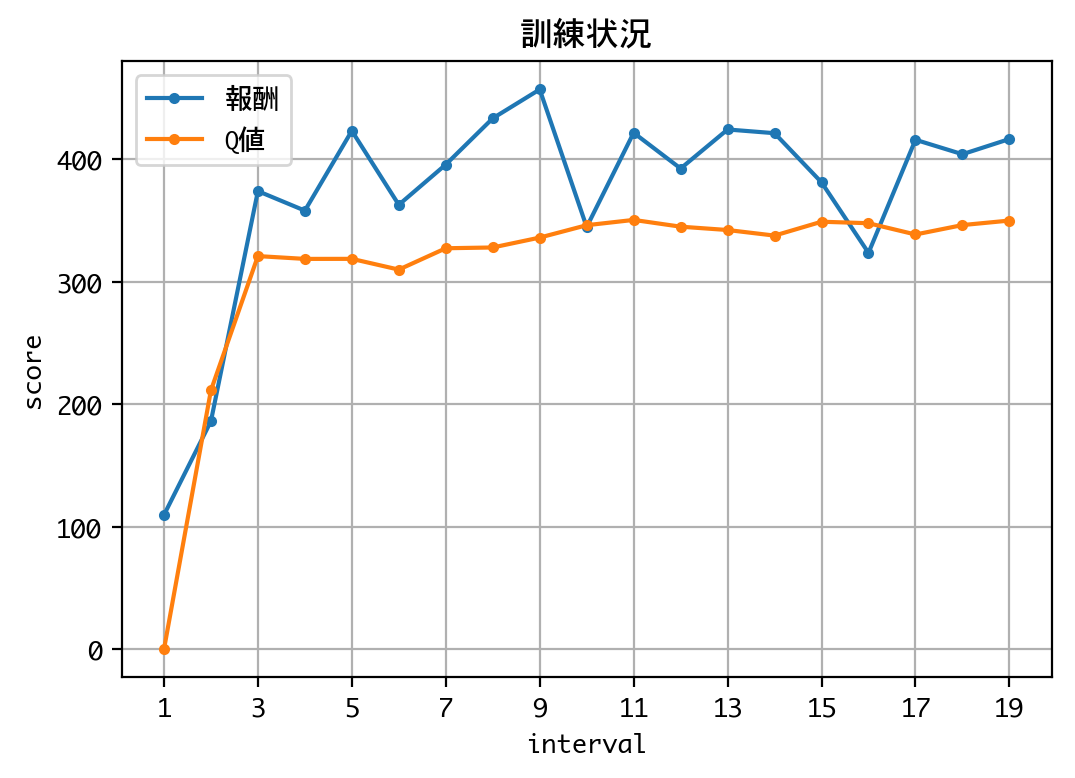

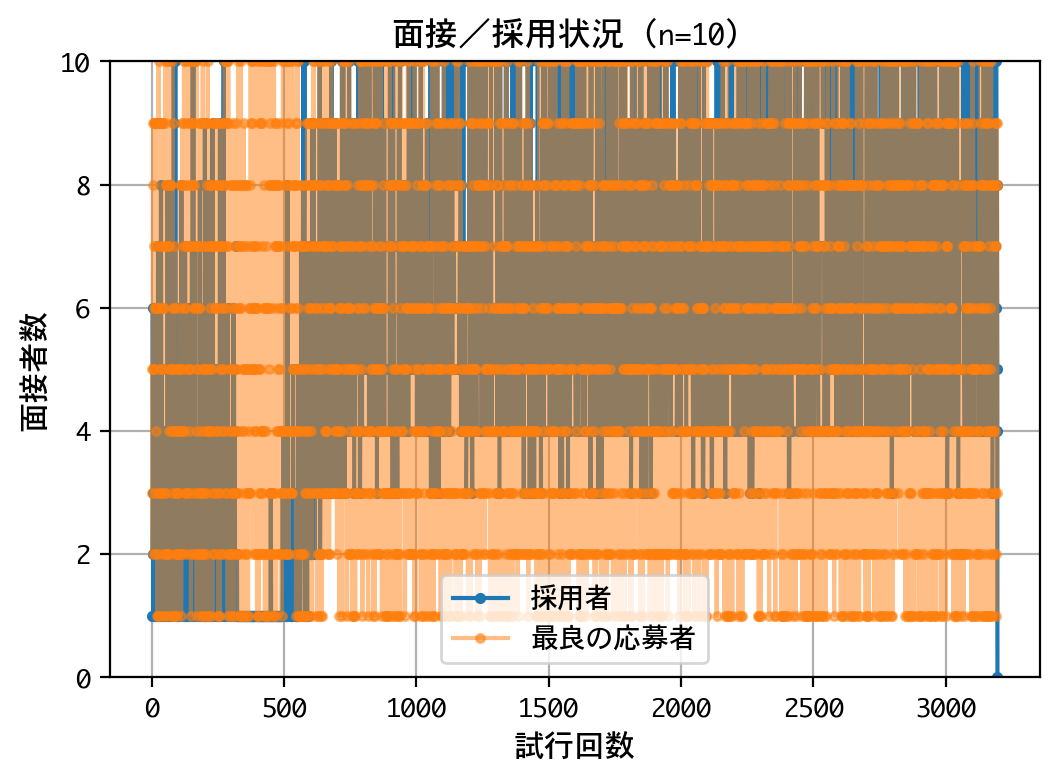

In [3]:
d = DQNSecretary(n=NUMS, recycle=False)
h = d.train(nb_steps=20000, log_interval=1000, verbose=1)
visualize_adopting(d.env)

訓練状況を見る限り、Q値が収束しているので、DQNは学習を終えたようです。

面接／採用状況を見ると、試行回数が6~700回を超えたあたりから、なんらかのポリシーにしたがって、採用を行なっているようです。

## 訓練結果の検証

学習効果を測定し、訓練結果を検証してみましょう。まずは1回、visualizeモードで回してみます。

In [4]:
d = DQNSecretary(n=NUMS, recycle=True)
h = d.test(nb_episodes=1, verbose=1, visualize=True)

モデルを作成します。
モデルを作成しました。
訓練済み重みを読み込みます。
訓練済み重みを読み込みました。
Testing for 1 episodes ...

10人中2人目（暫定順位：2位）

10人中3人目（暫定順位：2位）

10人中4人目（暫定順位：2位）

10人中5人目（暫定順位：4位）

10人中6人目（暫定順位：5位）

10人中7人目（暫定順位：3位）

10人中8人目（暫定順位：1位）

おめでとうございます！  最良の応募者を採用できました。
Episode 1: reward: 1000.000, steps: 8


DQNは、幸運にも、最良（最善）の応募者を採用できたようです。（なお、10人中2人目から始まるのは、Keras-RLが初期画面をレンダリングする要求を出してくれないためです。）

それでは、1000回転させて、採用成功率を確認してみましょう。

モデルを作成します。
モデルを作成しました。
訓練済み重みを読み込みます。
訓練済み重みを読み込みました。
採用成功率(1000回)：0.388


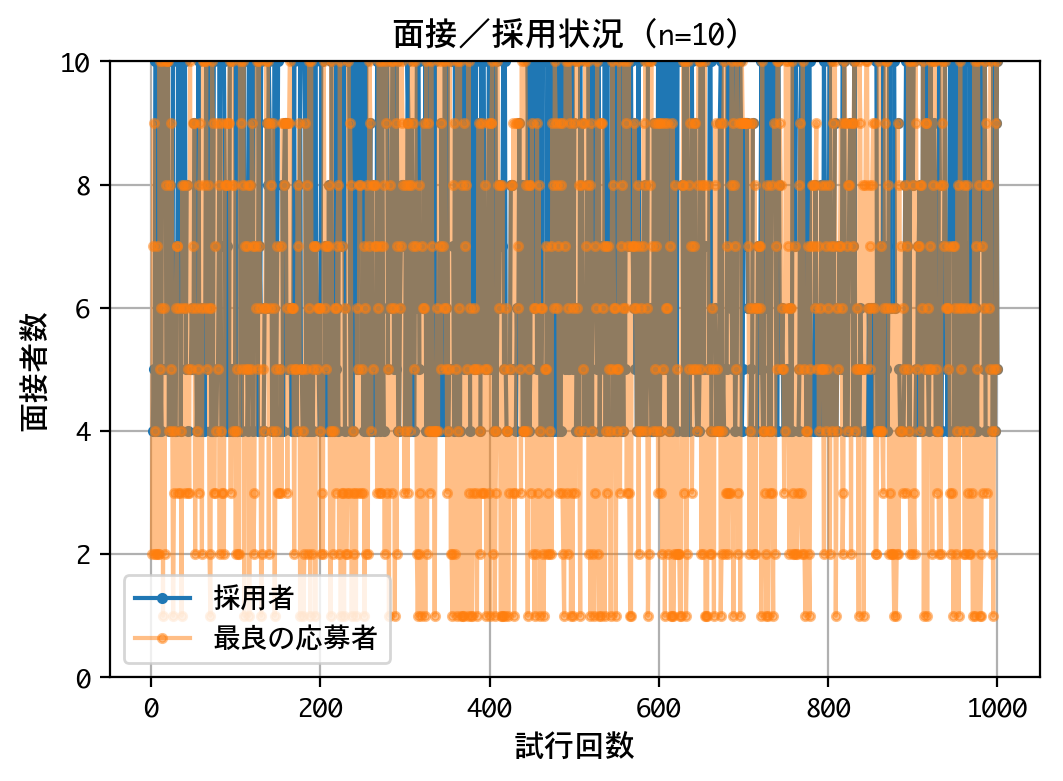

In [5]:
d = DQNSecretary(n=NUMS, recycle=True)
h = d.test(nb_episodes=1000, visualize=False, verbose=0)

rwds = h.history['episode_reward']
win_rate = sum(rwd > 0 for rwd in rwds) / len(rwds)
print('採用成功率(1000回)：' + str(win_rate))

visualize_adopting(d.env)

最適ポリシーに従った場合の採用成功率（約37%）に近しい数字を叩き出しています。素晴らしい結果と言えるでしょう。

ではでは、最後にQ値——ニューラルネットワークにより近似されたQ値——を直接確認してみましょう。相対順位ごとに、採用する／しないのQ値をグラフに描画します。横軸の人数というのは、何人目の面接かということを表しています。緑の縦棒は、ここのラインで戦略を変えなさいという理論値を示しています。

まずは、相対順位1位について見てみましょう。

モデルを作成します。
モデルを作成しました。
訓練済み重みを読み込みます。
訓練済み重みを読み込みました。


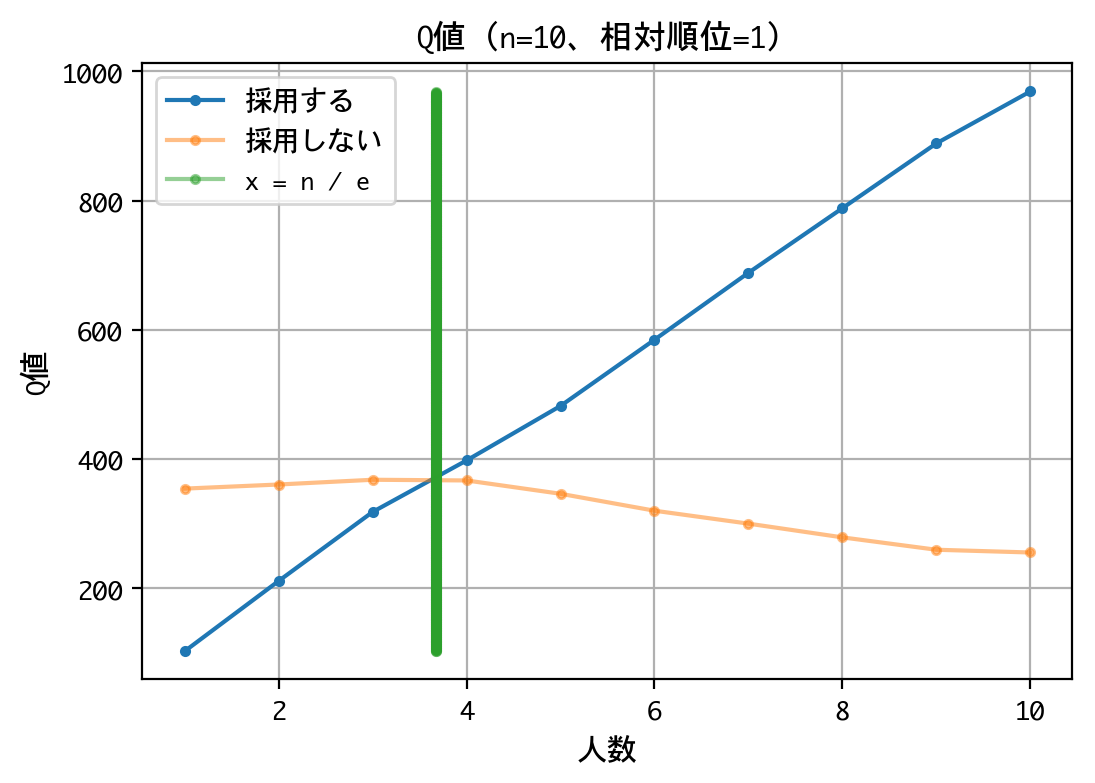

In [6]:
d = DQNSecretary(n=NUMS, recycle=True)
visualize_q(d, 1)

緑の縦棒を境に、採用する／しないのQ値が逆転しています。すなわち、3人目までは一番良いと思える応募者が現れてもスキップし、4人目からは一番良いと思える応募者が現れたら採用しなさいと言っています。理論どおりで、とても美しい結果です。証明をトレースしてもなお、どこかで釈然としない気持ちがあったのですが、DQNにこうして示されると、認めざるを得ません。

相対順位2位以降も見てみましょう。

モデルを作成します。
モデルを作成しました。
訓練済み重みを読み込みます。
訓練済み重みを読み込みました。


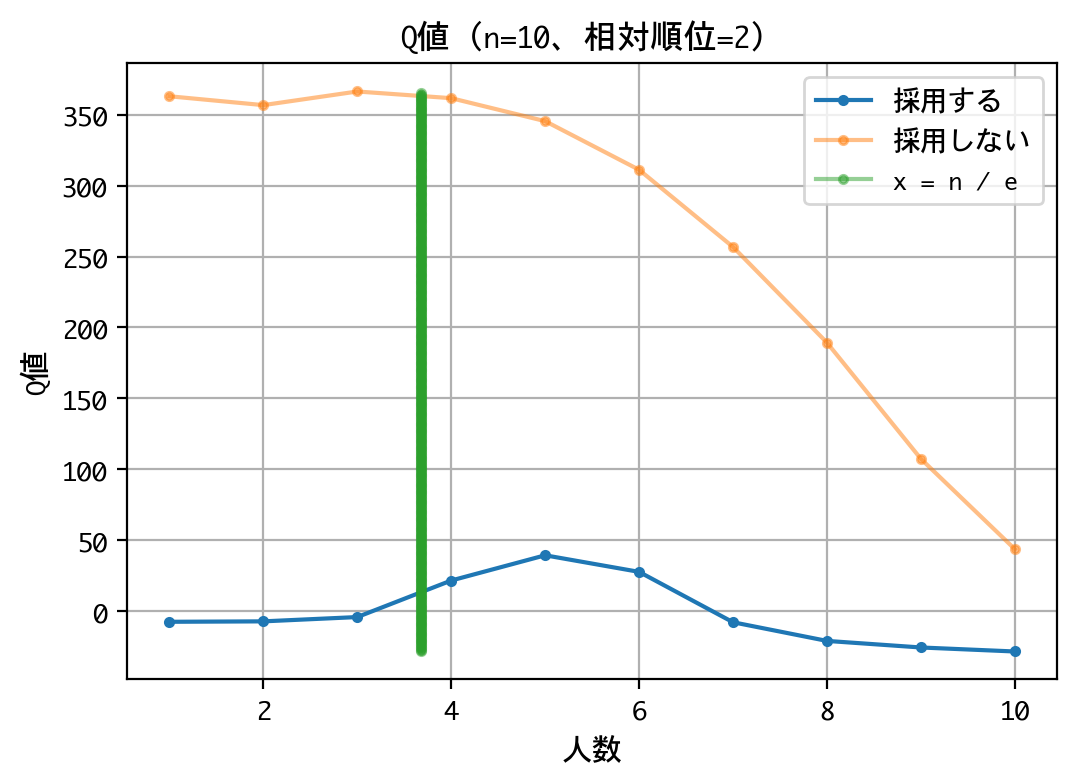

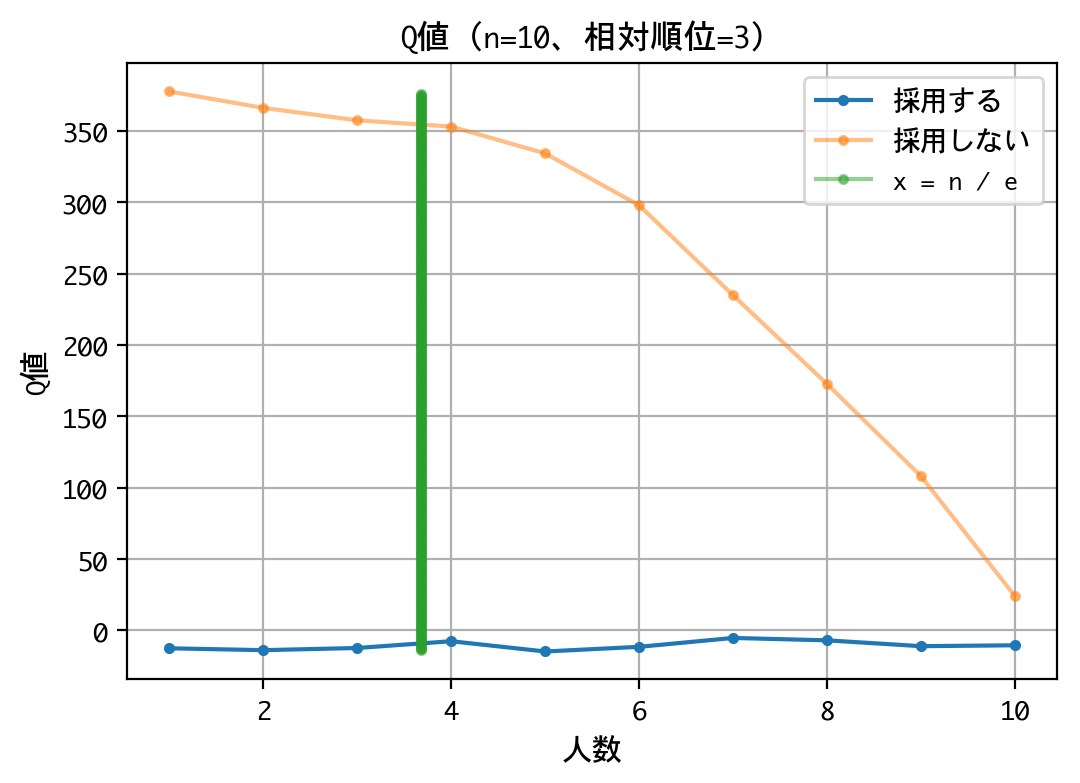

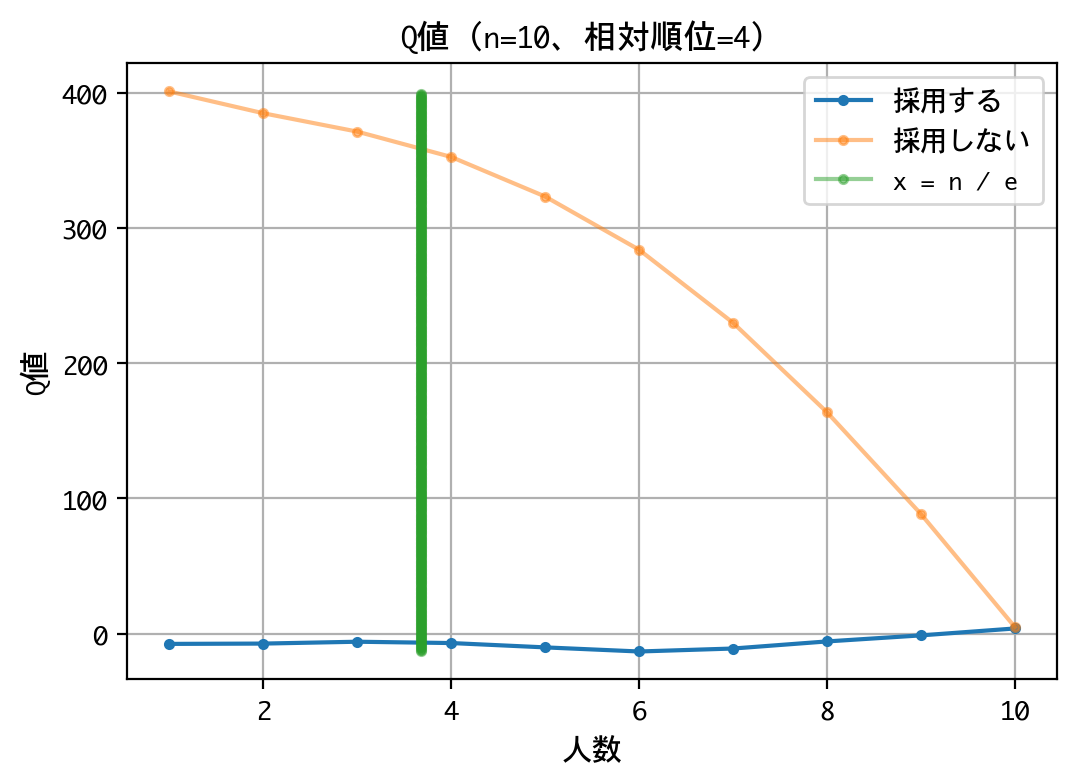

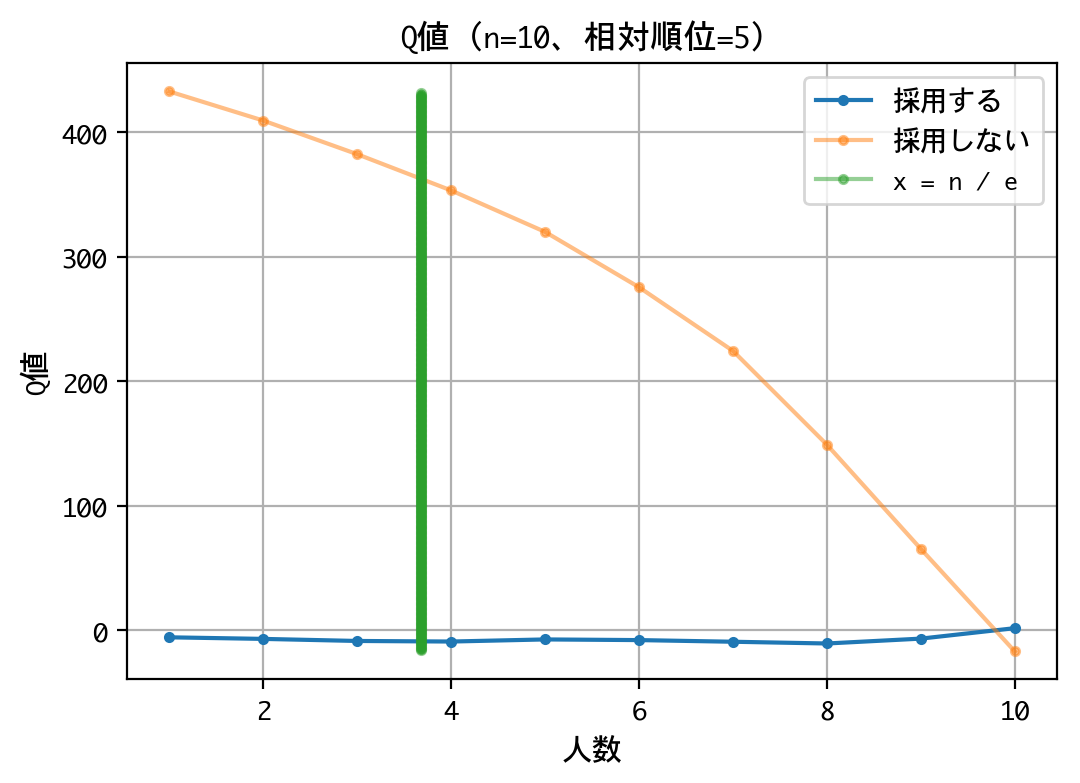

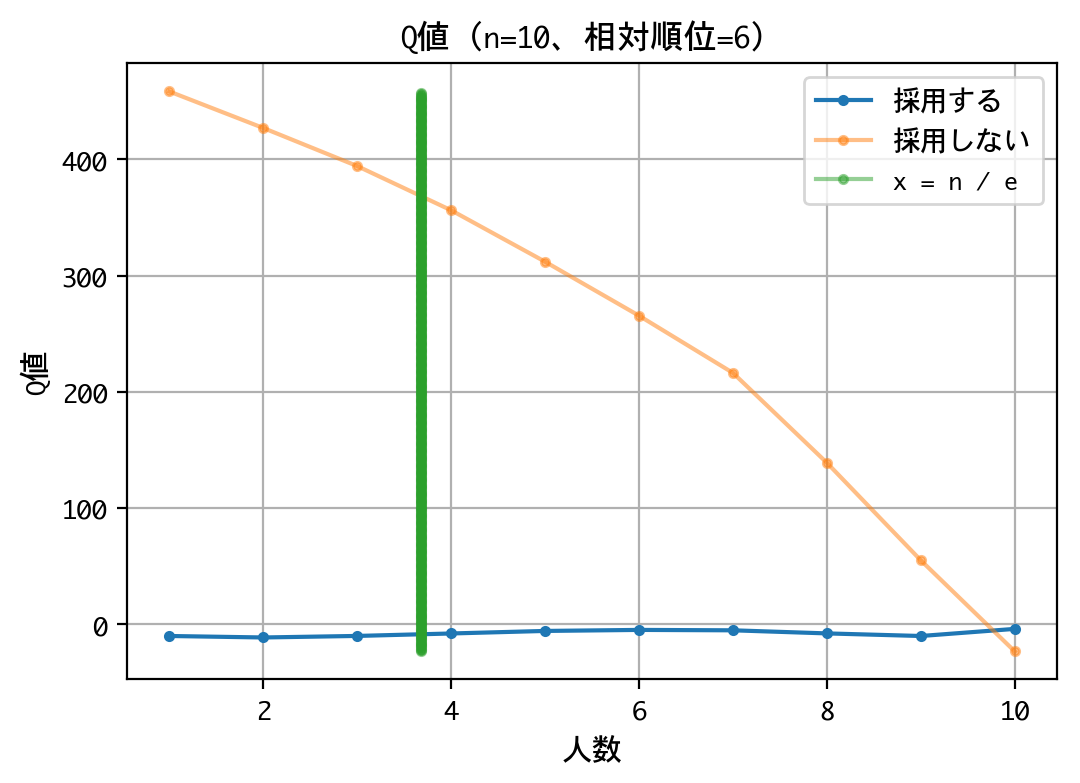

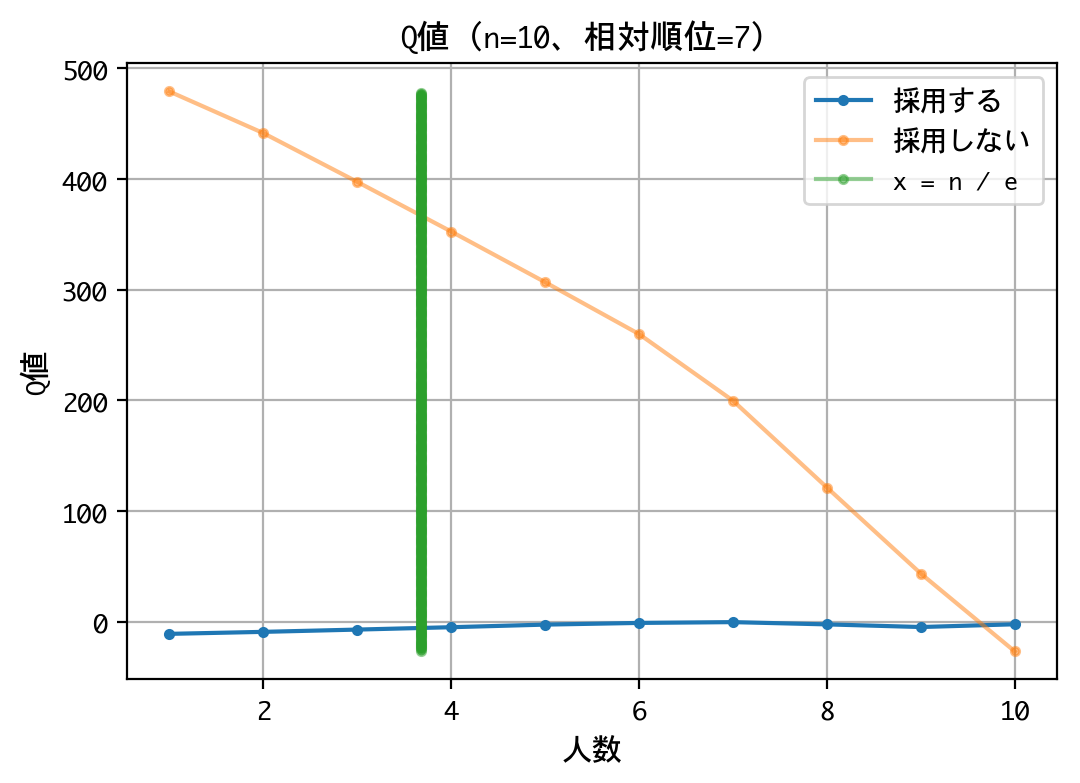

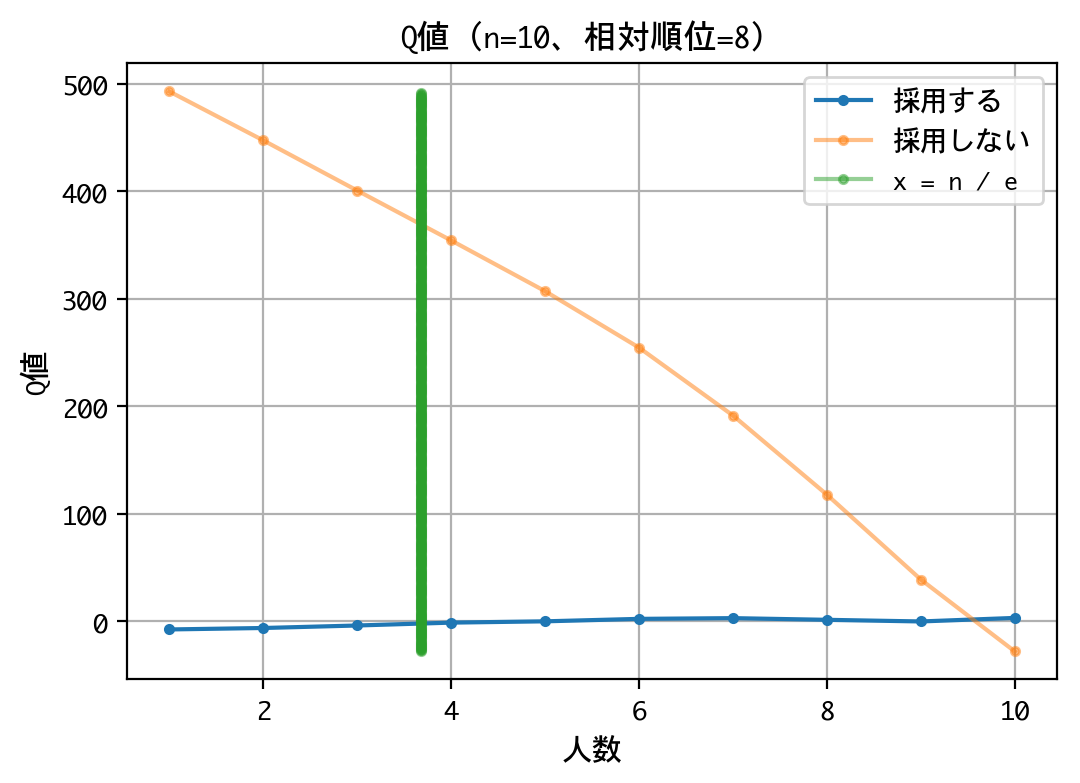

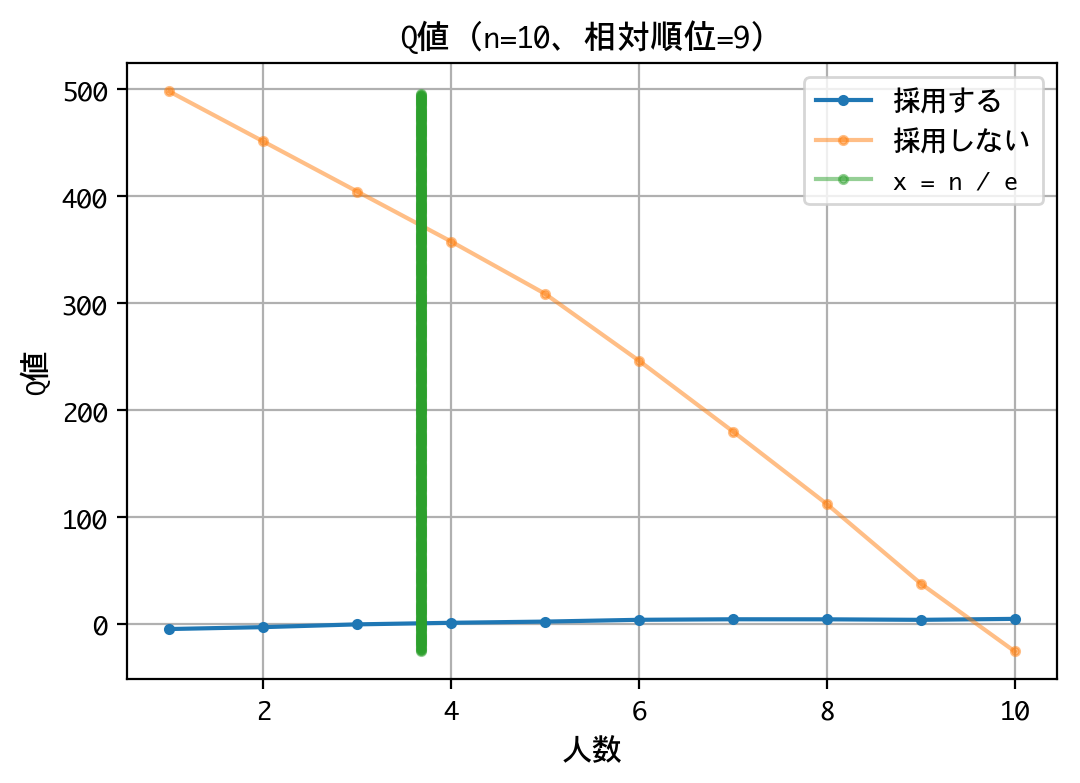

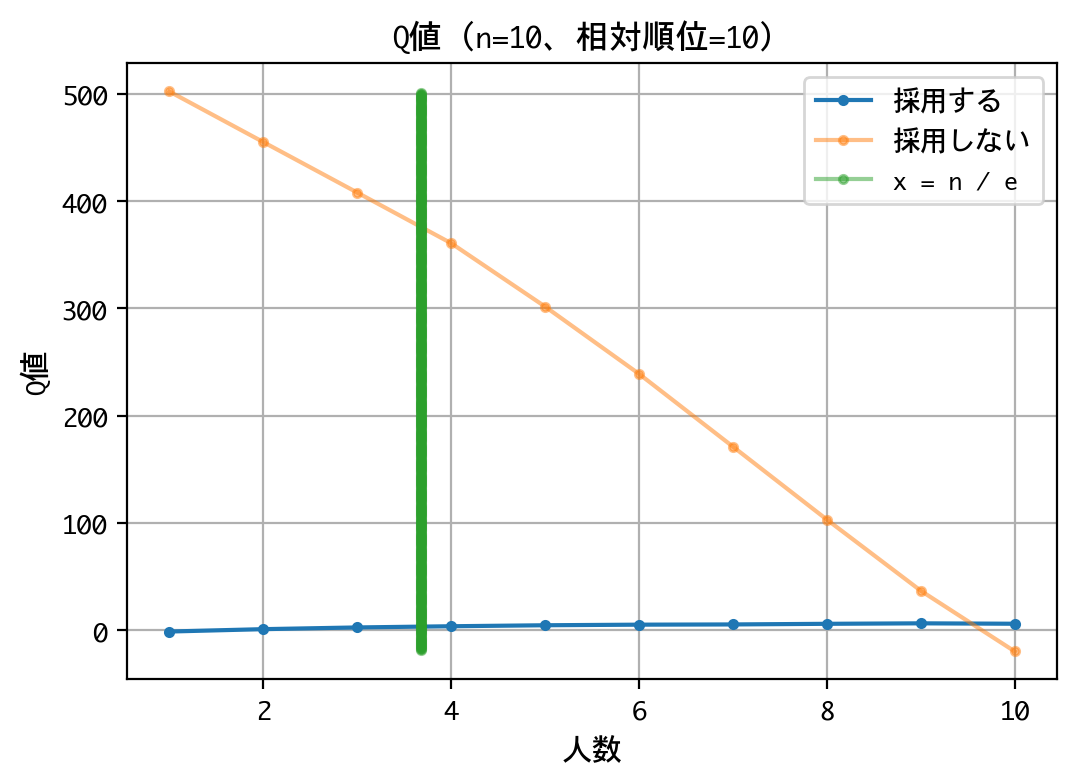

In [7]:
d = DQNSecretary(n=NUMS, recycle=True)
for i in range(2, NUMS + 1):
    visualize_q(d, i)

いずれの順位でも原則、採用は行わない戦略です。最後の一人に限っては、採用するものとしないものがありますが、その理由は、以下の報酬が等価（0点）であるためでしょう。

- 次善以下の応募者を採用した
- 一人も採用できず面接を終えた

なお、本訓練は10回行いましたが、理論値の4人目でなく、5人目から採用しなさいという結果になるときもあり、結果がブレました。ともあれ、採用成功率は平均39.77%を記録していたので、良好な結果と言えるでしょう。

|訓練|何人目から採用？|採用成功率|
|:-:|:-:|:-:|
|1|**4人目**|38.8%|
|2|5人目|42.8%|
|3|**4人目**|37.7%|
|4|5人目|41.5%|
|5|**4人目**|39.8%|
|6|5人目|39.5%|
|7|5人目|40.1%|
|8|**4人目**|36.3%|
|9|**4人目**|41.7%|
|10|**4人目**|39.5%|

## 結果のまとめ

- 秘書問題をゲーム化し、DQNにプレーさせた結果、応募者数10人の場合において、DQNは攻略法——最初の3人をスキップし、以降、これまでで一番良い応募者が現れたら採用する——を編み出した
- その結果として、数学的に導き出される採用成功率（＝約37%）に近い成功率：38.8%を叩き出した
- 4人までスキップするよう学習することもあったが、採用成功率は平均39.77%を記録した

## 考察、振り返り

応募者数が10人というのは少なすぎたかと後から思いましたが、美しい結果が得られたので、そのままにしています。応募者数が多い場合についてお試しになりたい方は、拙いコードですが、上述のソースコードを使って確認して頂ければと思います。

結果がブレた理由は不明ですが、訓練回数やハイパーパラメータを調整すれば安定するのかもしれません。

また、理論的にわかっていることを、DQNで再確認して何がうれしいのかと問われれば、答えに窮しますが。

しいて言えば、こういう意思決定に関わる理論の根拠を説明するのに、相手（例えば社長）が十分な数学的リテラシーを持っているとは限らないわけで。そうではなくて「囲碁の世界チャンピオンを倒したアルファ碁でも使われている手法を使ってシミュレーションしたら、同じ結果を確認できたよ」なんて説明できたら、説得力も増すのではないでしょうか。

以上をもって、考察、振り返りに代えたいと思います。